In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from cell_paint_seg.utils import get_id_to_path
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import exposure
import umap
import umap.plot
from graspologic.plot import heatmap
import pickle

In [3]:
data_paths = ["/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/stats/Image.csv",
"/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/stats/Image.csv"]

channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]

# Get data

In [14]:
feats_to_exclude = ['Metadata_Series','Metadata_Site','Metadata_Well','Metadata_WellColumn','Metadata_WellRow',
                   'AreaShape_Orientation', 'AreaShape_BoundingBoxMaximum_X','AreaShape_BoundingBoxMaximum_Y','AreaShape_BoundingBoxMinimum_X',
                  'AreaShape_BoundingBoxMinimum_Y','AreaShape_Center_X','AreaShape_Center_Y',
                  'Children_Cytoplasm_Count',
                  'Location_CenterMassIntensity_X_scaled_AGP','Location_CenterMassIntensity_Y_scaled_AGP','Location_CenterMassIntensity_Z_scaled_AGP',
                  'Location_CenterMassIntensity_X_scaled_DNA','Location_CenterMassIntensity_Y_scaled_DNA','Location_CenterMassIntensity_Z_scaled_DNA','Location_CenterMassIntensity_X_scaled_ER',
                  'Location_CenterMassIntensity_Y_scaled_ER','Location_CenterMassIntensity_Z_scaled_ER','Location_CenterMassIntensity_X_scaled_mito','Location_CenterMassIntensity_Y_scaled_mito',
                  'Location_CenterMassIntensity_Z_scaled_mito','Location_CenterMassIntensity_X_scaled_RNA','Location_CenterMassIntensity_Y_scaled_RNA','Location_CenterMassIntensity_Z_scaled_RNA',
                  'Location_MaxIntensity_X_scaled_DNA','Location_MaxIntensity_X_scaled_AGP','Location_MaxIntensity_X_scaled_mito','Location_MaxIntensity_X_scaled_ER','Location_Center_X','Location_Center_Y',
                  'Location_MaxIntensity_X_scaled_RNA','Location_MaxIntensity_Y_scaled_DNA','Location_MaxIntensity_Y_scaled_AGP','Location_MaxIntensity_Y_scaled_mito','Location_MaxIntensity_Y_scaled_ER',
                  'Location_MaxIntensity_Y_scaled_RNA','Location_MaxIntensity_Z_scaled_DNA','Location_MaxIntensity_Z_scaled_AGP','Location_MaxIntensity_Z_scaled_mito','Location_MaxIntensity_Z_scaled_ER',
                  'Location_MaxIntensity_Z_scaled_RNA',
                  'Neighbors_AngleBetweenNeighbors_Adjacent','Neighbors_AngleBetweenNeighbors_25','Neighbors_FirstClosestObjectNumber_Adjacent','Neighbors_SecondClosestObjectNumber_Adjacent','Number_Object_Number',
                  'Parent_EdgeNuclei','Parent_Nuclei','Neighbors_FirstClosestObjectNumber_25','Neighbors_SecondClosestObjectNumber_25']

def include_feat(feat_name):
    for feat_to_exclude in feats_to_exclude:
        if feat_to_exclude in feat_name:
            return False
    return True

dfs = []
for i, data_path in enumerate(data_paths):
    df = pd.read_csv(data_path)

    row = [int(fname[1:3]) for fname in list(df["FileName_AGP"])]
    col = [int(fname[4:6]) for fname in list(df["FileName_AGP"])]
    well = [(i, r, c) for r, c in zip(row, col)]
    field = [int(fname[7:9]) for fname in list(df["FileName_AGP"])]
    id = [fname[:12] for fname in list(df["FileName_AGP"])]

    df["Row"] = row 
    df["Column"] = col 
    df["Well"] = well
    df["Field"] = field 
    df["ID"] = id

    col_names = list(df.columns)
    col_names = [col_name for col_name in col_names if "Mean_" in col_name]
    col_names = [col_name for col_name in col_names if include_feat(col_name)]
    col_names += ["Plate", "Row", "Column", "Well", "Field", "ID"]
    print(f"{len(col_names)} different features")
    df["Plate"] = i
    dfs.append(df[col_names])
df_means = pd.concat(dfs, axis="rows")


1183 different features
1183 different features


In [15]:
df_means

Mean_Cells_AreaShape_Area  Mean_Cells_AreaShape_BoundingBoxArea  \
0                   1456.465517                           5908.689655   
1                    845.127490                           3470.175299   
2                   1080.587879                           5438.181818   
3                    832.924242                           5009.196970   
4                    430.600000                            791.650000   
...                         ...                                   ...   
3451                2698.685714                           8220.771429   
3452                1384.000000                           5579.155556   
3453                1242.209302                           5603.790698   
3454                2117.061224                           6189.571429   
3455                2498.111111                           7972.111111   

      Mean_Cells_AreaShape_Compactness  Mean_Cells_AreaShape_ConvexArea  \
0                             6.544091                      3550.931034   
1                             4.428518                      1893.756972   
2                             6.694690                      3001.648485   
3                             5.711963                      2333.196970   
4                             1.645270                       533.200000   
...                                ...                              ...   
3451                          4.515661                      5105.342857   
3452                          5.746711                      3203.277778   
3453                          6.407832                      3129.937984   
3454                          3.971784                      3728.877551   
3455                          4.099095                      4459.388889   

      Mean_Cells_AreaShape_Eccentricity  \
0                              0.747548   
1                              0.734166   
2                              0.763412   
3                              0.677029   
4                              0.571834   
...                                 ...   
3451                           0.723426   
3452                           0.774333   
3453                           0.799720   
3454                           0.711962   
3455                           0.784974   

      Mean_Cells_AreaShape_EquivalentDiameter  \
0                                   35.846839   
1                                   29.658284   
2                                   32.877313   
3                                   28.688462   
4                                   22.682065   
...                                       ...   
3451                                52.817371   
3452                                37.938589   
3453                                36.074134   
3454                                45.248633   
3455                                50.177251   

      Mean_Cells_AreaShape_EulerNumber  Mean_Cells_AreaShape_Extent  \
0                            -0.413793                     0.491677   
1                             0.151394                     0.531025   
2                            -0.078788                     0.479856   
3                             0.189394                     0.542344   
4                             0.700000                     0.672291   
...                                ...                          ...   
3451                         -1.314286                     0.504933   
3452                          0.111111                     0.490897   
3453                         -0.403101                     0.469208   
3454                         -1.632653                     0.499553   
3455                         -0.861111                     0.472556   

      Mean_Cells_AreaShape_FormFactor  Mean_Cells_AreaShape_MajorAxisLength  \
0                            0.476604                             73.122152   
1                            0.530555                             58.635545   
2                            0.5

In [16]:
df_conditions = pd.read_excel("/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/Answer ALS_Pilot2_March2024.xlsx")
df_conditions = df_conditions.iloc[:16, 2:]

data_dmso = []
data_autophagy = []
data_verdinexor = []
data_h2o2 = []
data_tunicamycin = []
data_importazole = []
data_celltype = []

for i, row in df_means.iterrows():
    r = row['Row']-1
    c = row['Column']-1
    p = row['Plate']

    condition = df_conditions.iloc[r, c]

    if c % 6 == 0:
        data_dmso.append(1)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 1:
        data_dmso.append(0)
        data_autophagy.append(1)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 2:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(float(condition))
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 3:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(float(condition))
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 4:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(float(condition))
        data_importazole.append(0)
    elif c % 6 == 5:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(float(condition))


    if p == 0:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("Control 1")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 18) or (r >= 8 and c < 18 and c >= 12):
            data_celltype.append("Control 2")
        else:
            data_celltype.append("ALS 2")
    elif p == 1:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("ALS 2")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("Control 2")
        elif (r < 8 and r >= 6 and c >= 18) or (r >= 8 and r < 10 and c < 18 and c >= 12):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 12 and c < 18) or (r >= 8 and c < 12 and c >= 6):
            data_celltype.append("Control 1")
        else:
            data_celltype.append("EMPTY")


data = {"DMSO": data_dmso, "Autophagy": data_autophagy, "Verdinexor": data_verdinexor, "H2O2": data_h2o2, "Tunicamysin": data_tunicamycin, "Importazole": data_importazole, "Cell Type": data_celltype}
df_covariates = pd.DataFrame(data)

In [17]:
# why do we need this?
df_covariates.reset_index(drop=True, inplace=True)
df_means.reset_index(drop=True, inplace=True)

In [18]:
df = pd.concat((df_means, df_covariates), axis="columns")

# Compute distance matrix

In [19]:
aggregation_functions = {k: 'median' for k in list(df.columns) if "Mean_" in k}
aggregation_functions_2 = {k: 'first' for k in list(df.columns) if "Mean_" not in k}
aggregation_functions.update(aggregation_functions_2)
df_agg = df.groupby(df["Well"]).aggregate(aggregation_functions)

df_agg.sort_values(by=['Cell Type'], inplace=True)

col_names = list(df.columns)
col_names = [col_name for col_name in col_names if "Mean_" in col_name]
print(len(col_names))
df_feats_agg = df_agg[col_names]

1177


In [20]:
feats = df_feats_agg.to_numpy()
print(f"Fraction of finite feature values: {np.sum(np.isfinite(feats))/feats.size}")
feats = np.nan_to_num(feats)
D = pairwise_distances(feats, metric='cosine')

Fraction of finite feature values: 0.99565455961484


# Plot distance matrix

<Axes: >

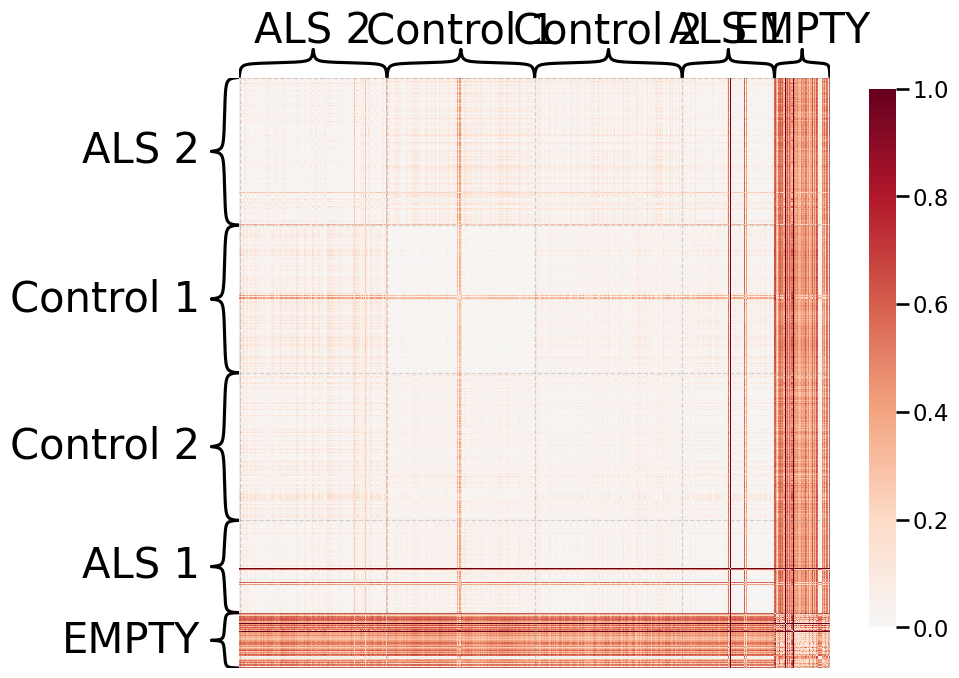

In [21]:
heatmap(D, inner_hier_labels=df_agg["Cell Type"])

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_39105/1344200157.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type1 = cell_types[i]
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_39105/1344200157.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type2 = cell_types[j]


Text(0.5, 1.0, 'Inter vs. Intra Cell Type Feature Distances (Mann-Whitney p-val: 0.00E+00)')

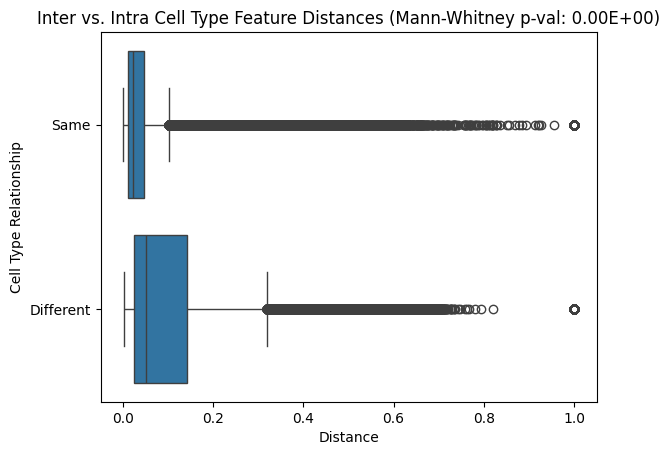

In [22]:
data_dist = []
data_type = []
data_ids = []
cell_types = df_agg["Cell Type"]

for i in range(D.shape[0]):
    type1 = cell_types[i]
    for j in range(i):
        type2 = cell_types[j]
        data_dist.append(D[i,j])
        data_ids.append((id[i], id[j]))
        if type1 == type2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(data = {"Distance": data_dist, "Cell Type Relationship": data_type, "ID Pair": data_ids})
sns.boxplot(df_types, x="Distance", y="Cell Type Relationship")

x = df_types[df_types["Cell Type Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Cell Type Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x,y, alternative="less")
plt.title(f"Inter vs. Intra Cell Type Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})")

## Search for features

In [23]:
data_feats = []
data_pvals = []

for col in tqdm(list(df_feats_agg.columns)):
    x = df_agg[(df_agg["Cell Type"] == "ALS 1") | (df_agg["Cell Type"] == "ALS 2")][col].to_numpy()
    y = df_agg[(df_agg["Cell Type"] == "Control 1") | (df_agg["Cell Type"] == "Control 2")][col].to_numpy()

    
    x = np.nan_to_num(x).reshape(-1,1)
    y = np.nan_to_num(y).reshape(-1,1)
    res = mannwhitneyu(x,y)

    data_feats.append(col)
    data_pvals.append(res.pvalue[0])

df_pvals = pd.DataFrame(data={"P-value": data_pvals, "Feature": data_feats})
# sns.histplot(df_pvals, x="P-value")

100%|██████████| 1177/1177 [00:02<00:00, 498.70it/s]


In [24]:
df_pvals.sort_values("P-value")

P-value                                            Feature
626   1.509176e-86    Mean_Nuclei_Texture_Entropy_scaled_DNA_3_02_256
400   2.747287e-86                     Mean_Nuclei_AreaShape_Solidity
532   3.387406e-86  Mean_Nuclei_Texture_AngularSecondMoment_scaled...
534   4.023006e-86  Mean_Nuclei_Texture_AngularSecondMoment_scaled...
1089  7.704609e-86  Mean_Somas_Texture_InverseDifferenceMoment_sca...
...            ...                                                ...
868   9.638681e-01      Mean_Somas_Intensity_MeanIntensity_scaled_AGP
364   9.674943e-01   Mean_Cells_Texture_Variance_scaled_AGP_10_01_256
362   9.841218e-01  Mean_Cells_Texture_SumVariance_scaled_mito_10_...
822   9.910775e-01                   Mean_Somas_AreaShape_Zernike_8_8
873   9.956143e-01    Mean_Somas_Intensity_MedianIntensity_scaled_AGP

[1177 rows x 2 columns]

# UMAP

In [29]:
np.save("/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/D.npy", D)

df_agg.to_csv("/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/df_agg.csv")

with open('/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/mapper.pickle', 'rb') as file:
    mapper = pickle.load(file)

#mapper = umap.UMAP().fit(D)

<Axes: >

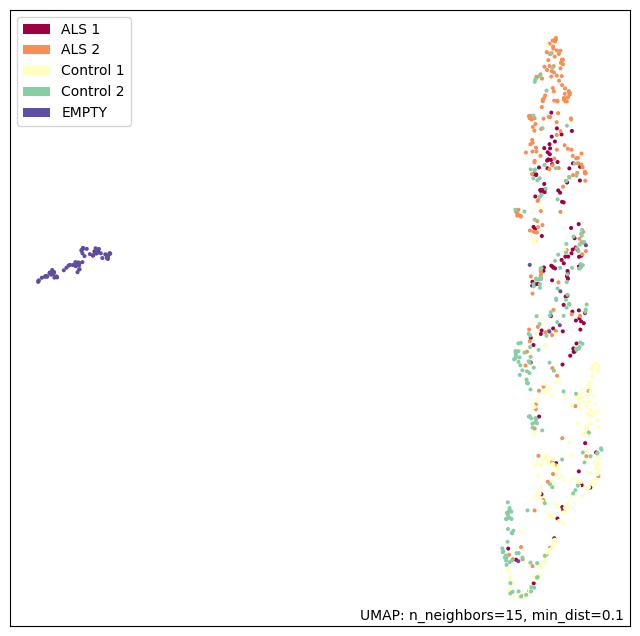

In [48]:
umap.plot.points(mapper, labels=df_agg["Cell Type"])


r11c08f01p01


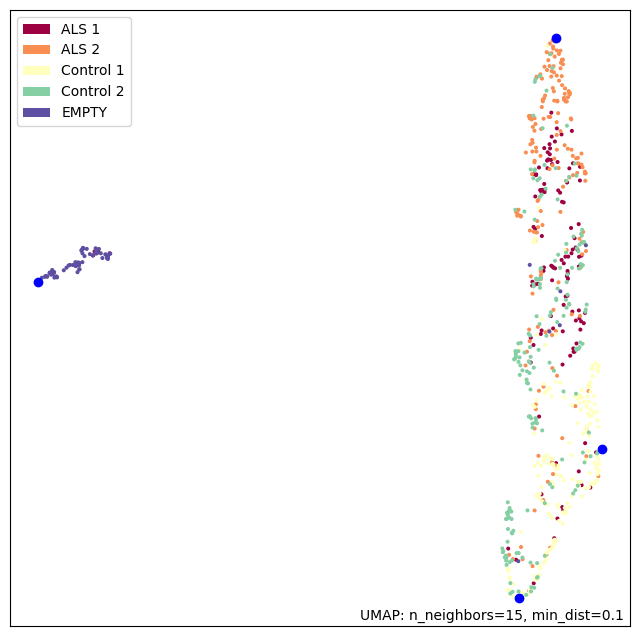

In [79]:
vert = np.argsort(mapper.embedding_[:,1])
horiz = np.argsort(mapper.embedding_[:,0])

bottom, top = vert[0], vert[-1]
left, right = horiz[0], horiz[-1]

ax = umap.plot.points(mapper, labels=df_agg["Cell Type"])
for extreme in [bottom, top, left, right]:
    ax.scatter(mapper.embedding_[extreme,0], mapper.embedding_[extreme,1], c="blue")
print(df_agg.iloc[top,:]["ID"])
plt.show()

# Get remote info

In [80]:
id_to_path_im_0 = get_id_to_path("/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/Images/", tag=".tif", remote=True)
id_to_path_seg_0 = get_id_to_path("/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/segmentations/", tag=".tif", remote=True)

id_to_path_im_1 = get_id_to_path("/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/Images/", tag=".tif", remote=True)
id_to_path_seg_1 = get_id_to_path("/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/segmentations/", tag=".tif", remote=True)

In [81]:
def plot(id, id_to_path_im, id_to_path_seg):
    paths_ims = id_to_path_im[0][id]
    paths_segs = id_to_path_seg[0][id]

    images = read_ims(paths_ims, sftp_client=id_to_path_im[1])
    segs = read_ims(paths_segs, sftp_client=id_to_path_seg[1])

    image_dna = images[channels.index("DNA")].astype('float') / (2**16-1)
    image_dna_adj = exposure.equalize_adapthist(image_dna, clip_limit=0.03, kernel_size = [s // 64 for s in image_dna.shape])
    image_rna = images[channels.index("RNA")].astype('float') / (2**16-1)
    image_rna_adj = exposure.equalize_adapthist(image_rna, clip_limit=0.03)
    image_agp = images[channels.index("AGP")].astype('float') / (2**16-1)
    image_agp_adj = exposure.equalize_adapthist(image_agp, clip_limit=0.03)
    image_rgb = np.stack([image_agp, image_rna, image_dna], axis=2)
    image_rgb_adj = np.stack([image_agp_adj, image_rna_adj, image_dna_adj], axis=2)

    seg_cell, seg_soma, seg_nuc = segs
    seg_cyto = np.logical_and(seg_soma > 0, seg_nuc == 0)

    seg_cell_masked = np.ma.masked_array(seg_cell, mask=seg_cell == 0)
    seg_soma_masked = np.ma.masked_array(seg_soma, mask=seg_soma == 0)
    seg_nuc_masked = np.ma.masked_array(seg_nuc, mask=seg_nuc == 0)
    seg_cyto_masked = np.ma.masked_array(seg_cyto, mask=seg_cyto == 0)


    f, axs = plt.subplots(nrows=1, ncols=3, dpi=300)

    axs[0].imshow(image_rgb, cmap="gray")
    axs[0].set_title(f"Image {id}")
    axs[1].imshow(image_rgb_adj, cmap="gray")
    axs[2].imshow(image_dna, cmap="gray")
    axs[2].imshow(seg_cell_masked % 20, cmap="tab20", alpha=0.5)
    axs[2].imshow(seg_cyto_masked, cmap="Accent", alpha=0.7)
    axs[2].imshow(seg_nuc_masked > 0, cmap="Set1", alpha=0.7)

    for ax in axs.flatten():
        ax.axis("off")


# Plot extremes

ALS 2
(0, 12, 12)
ALS 2
(1, 12, 19)
ALS 2
(0, 4, 14)
ALS 2
(0, 15, 10)
ALS 2
(0, 11, 8)


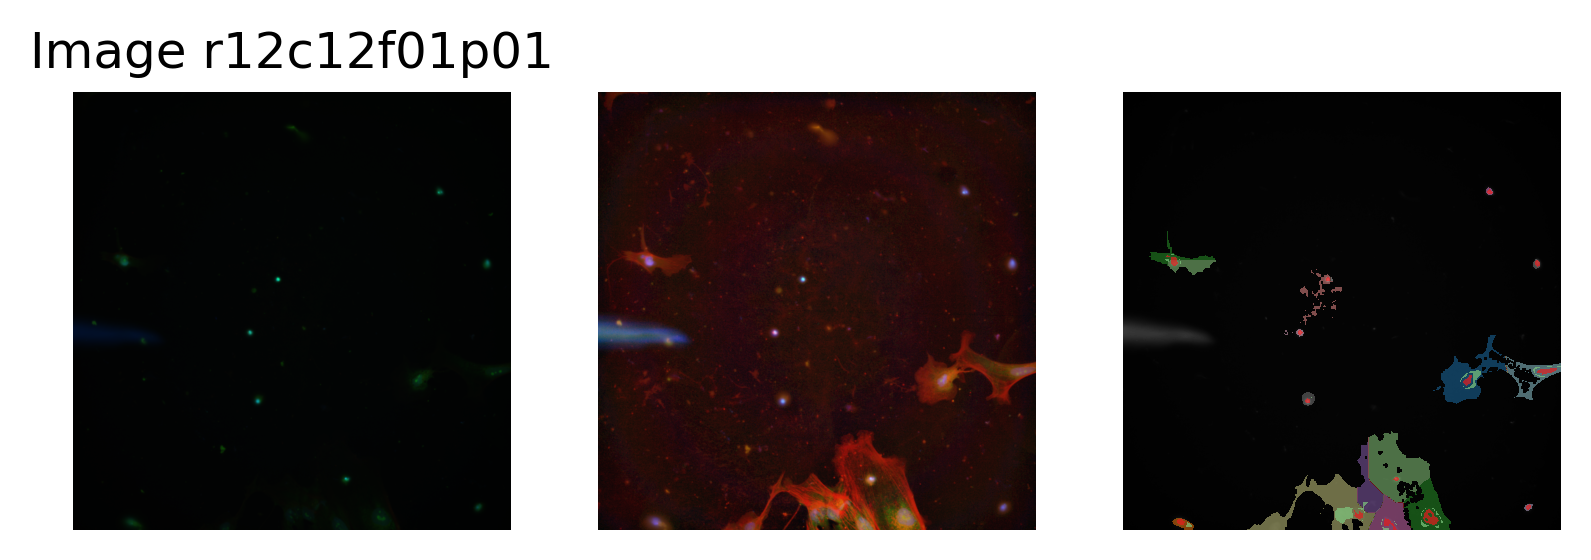

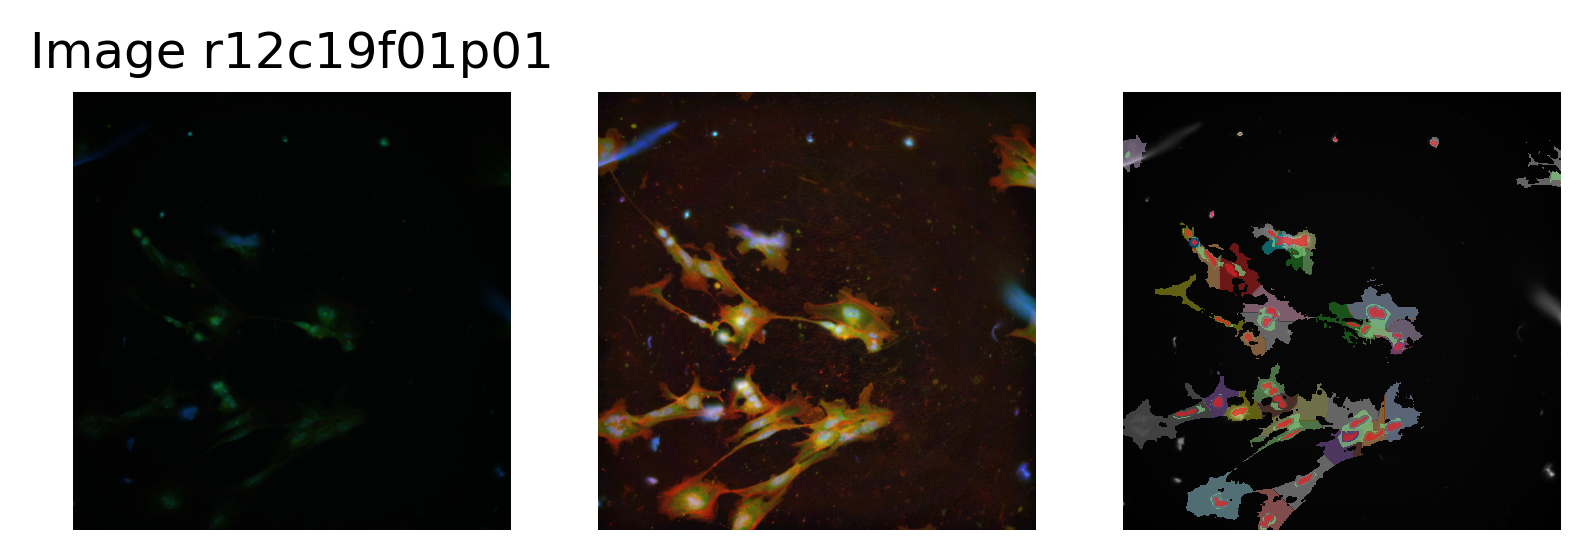

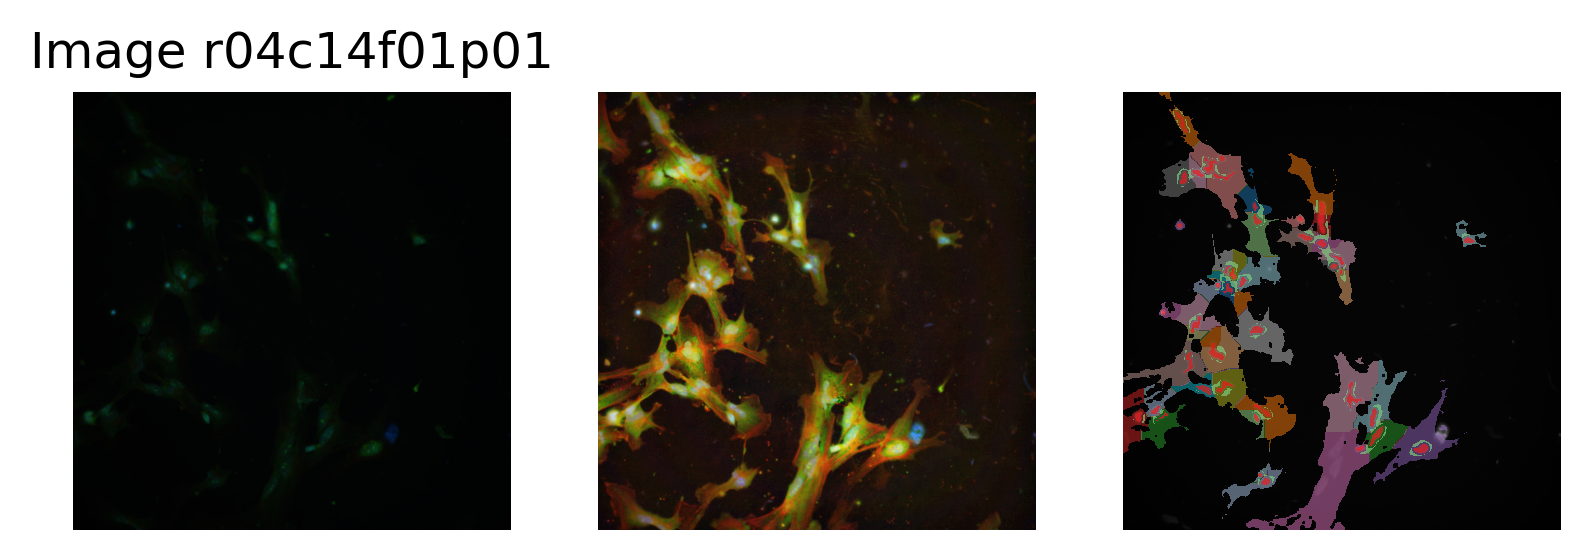

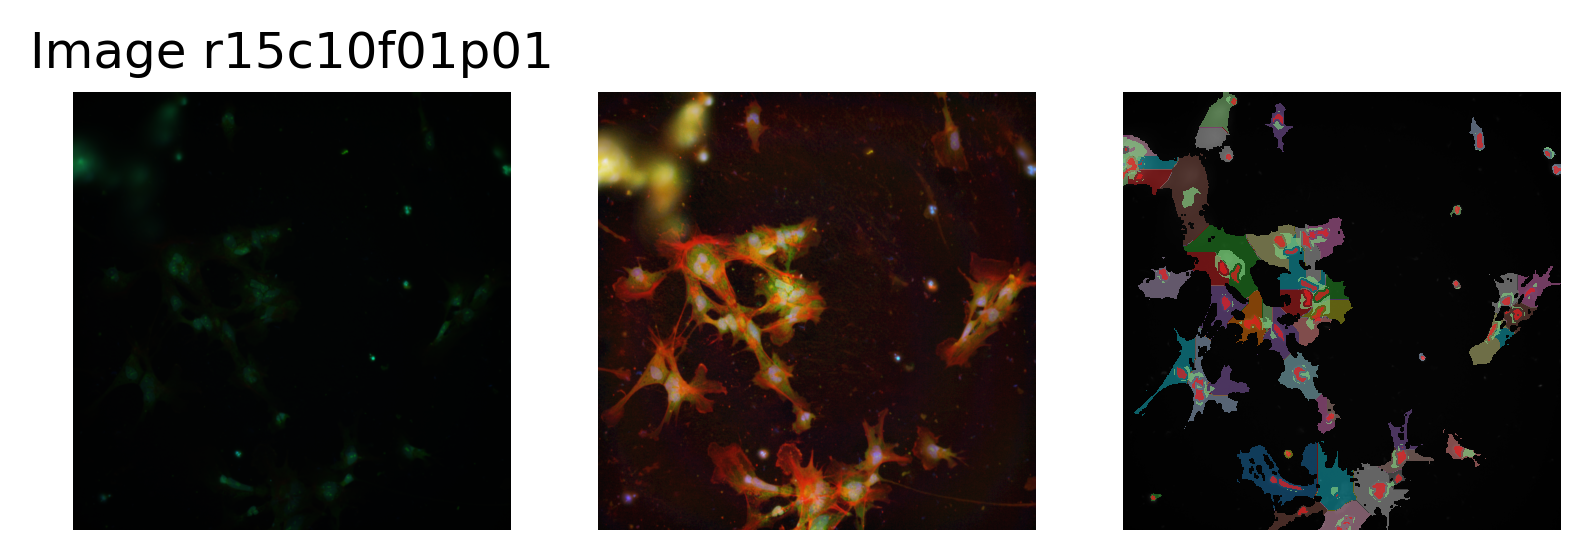

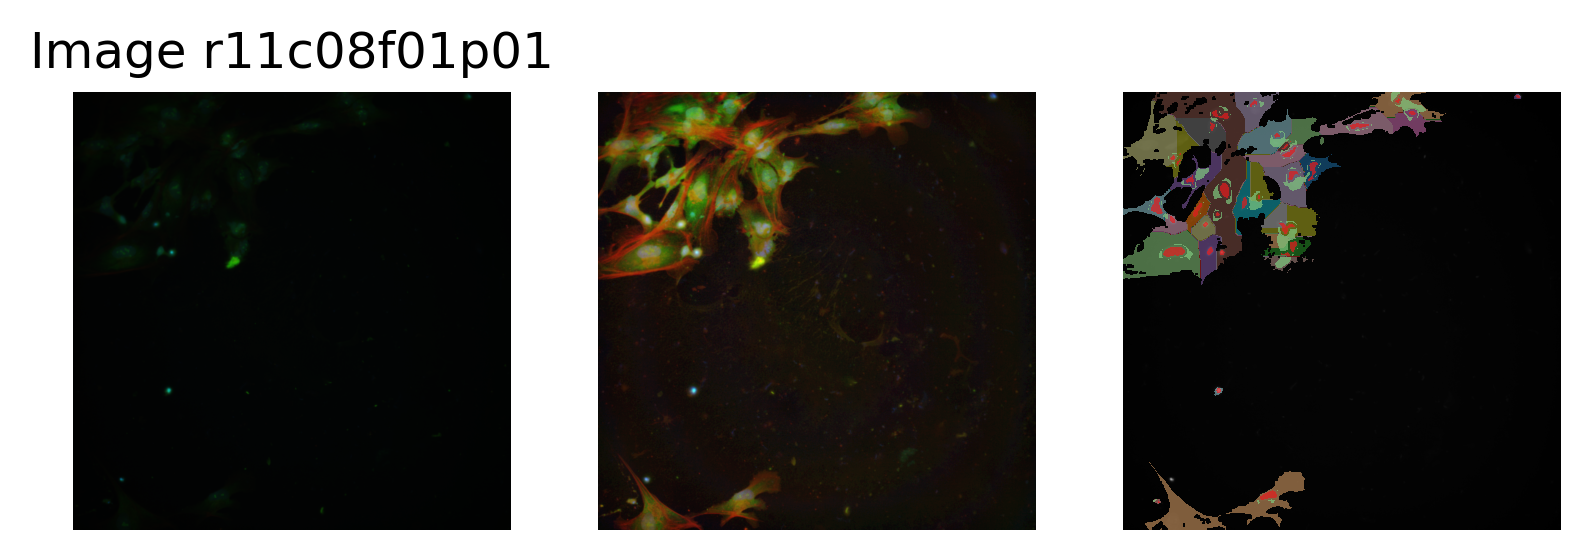

In [86]:
for extreme in vert[-5:]:
    well = df_agg.iloc[extreme,:]["Well"]
    id = df_agg.iloc[extreme,:]["ID"]
    print(df_agg.iloc[extreme,:]["Cell Type"])
    print(well)
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

Control 1
Control 1
Control 1
Control 1
ALS 1


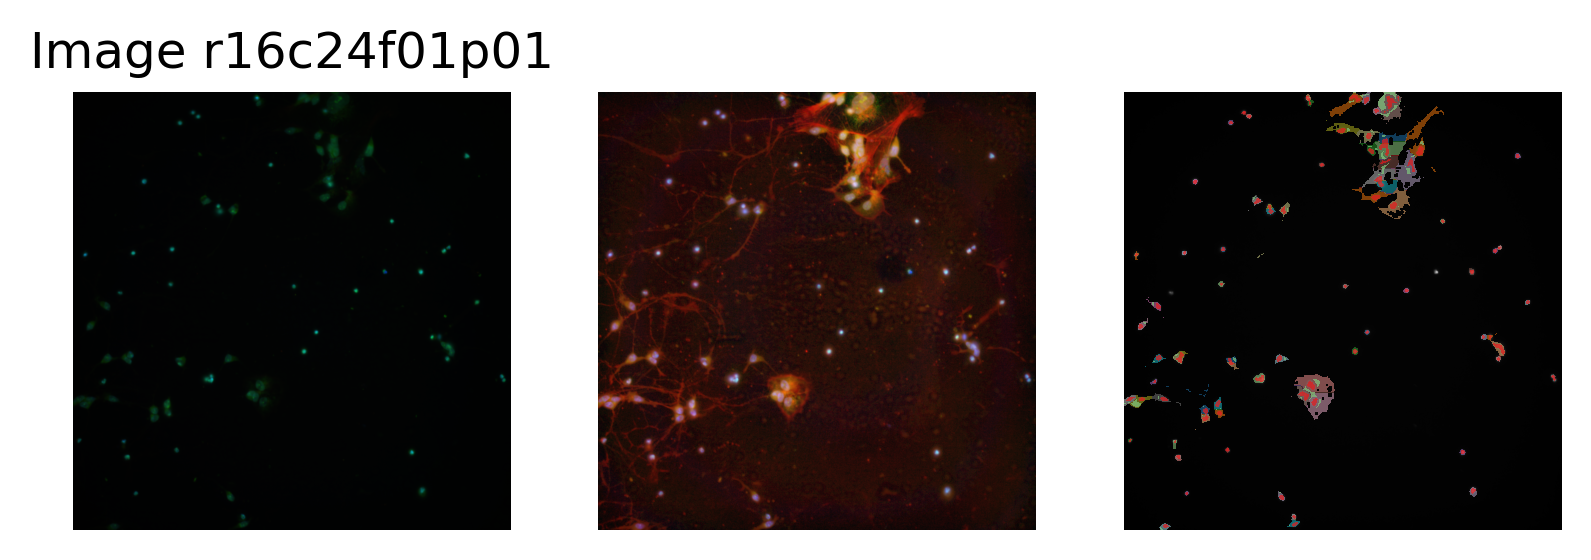

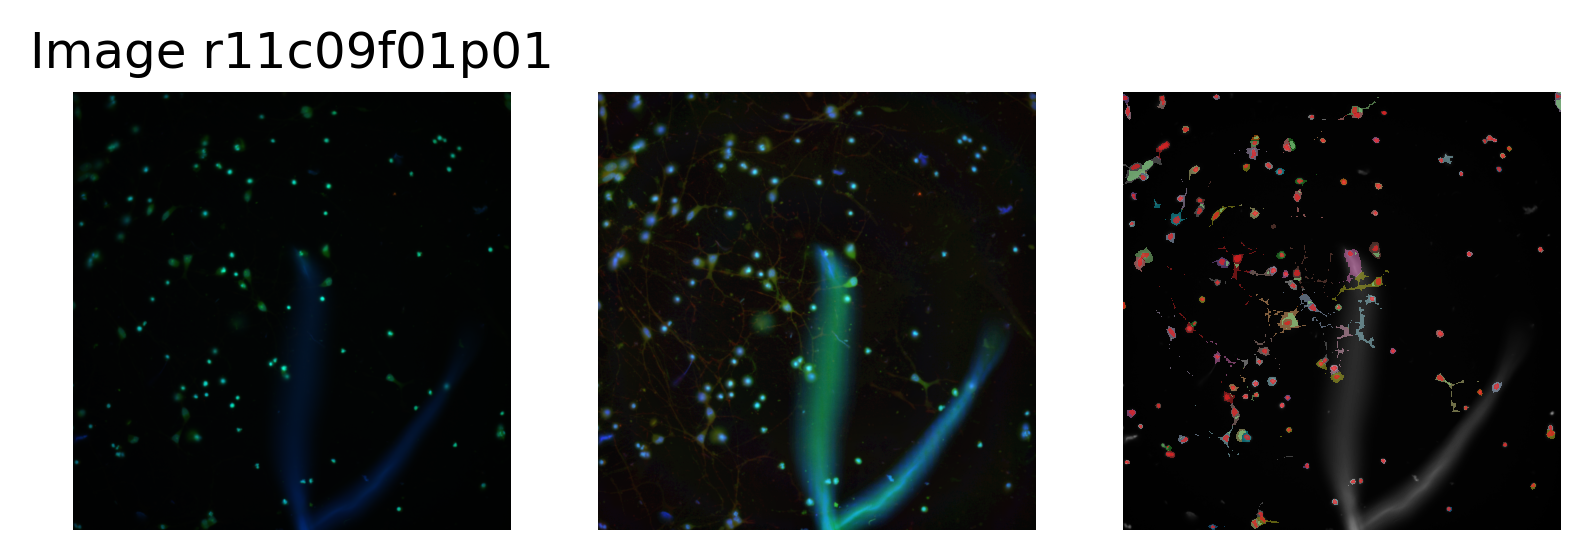

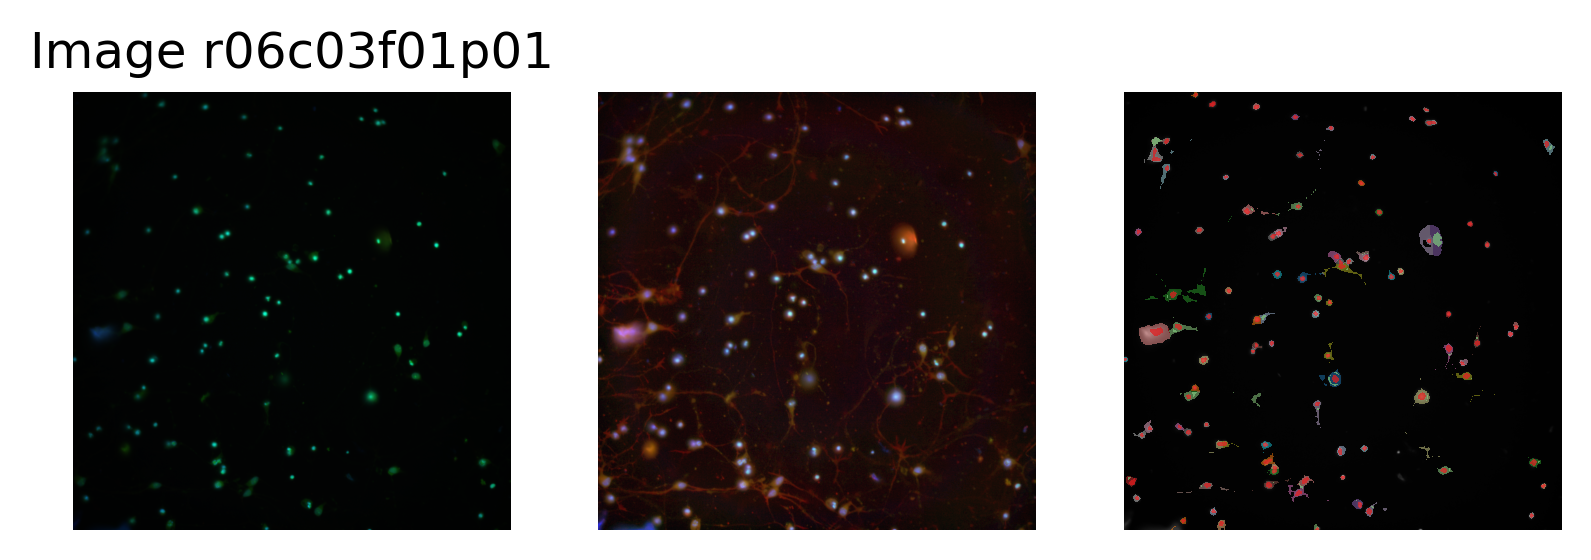

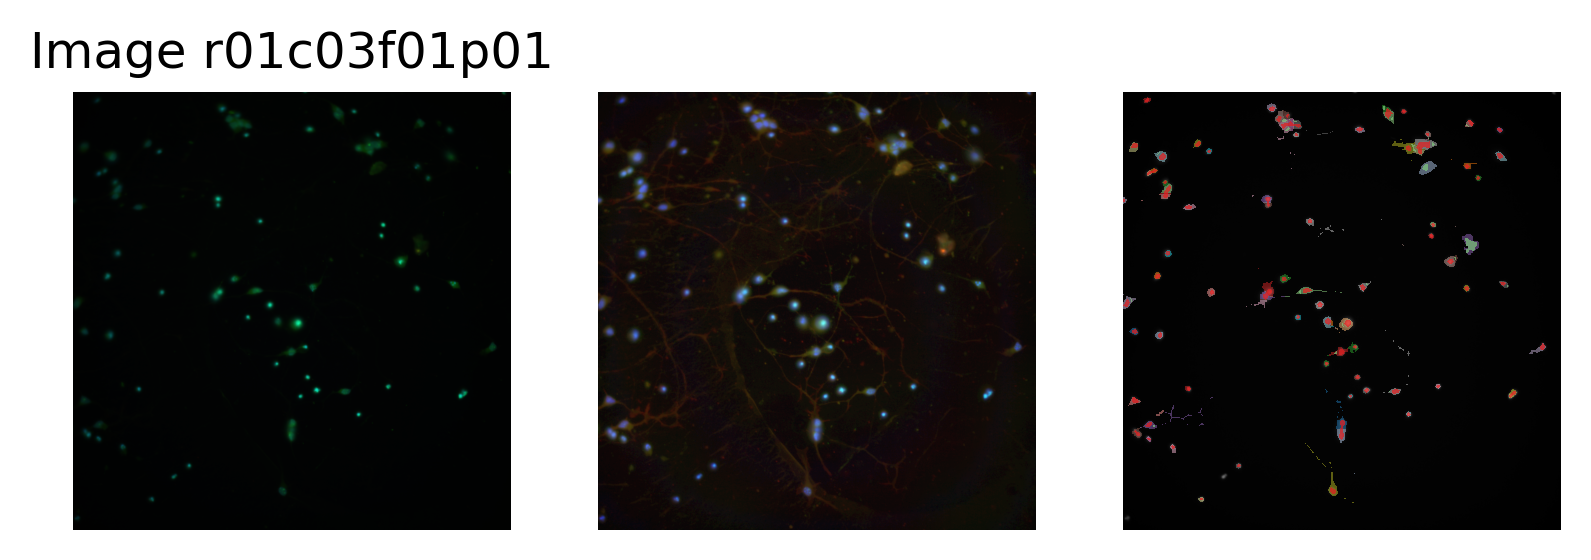

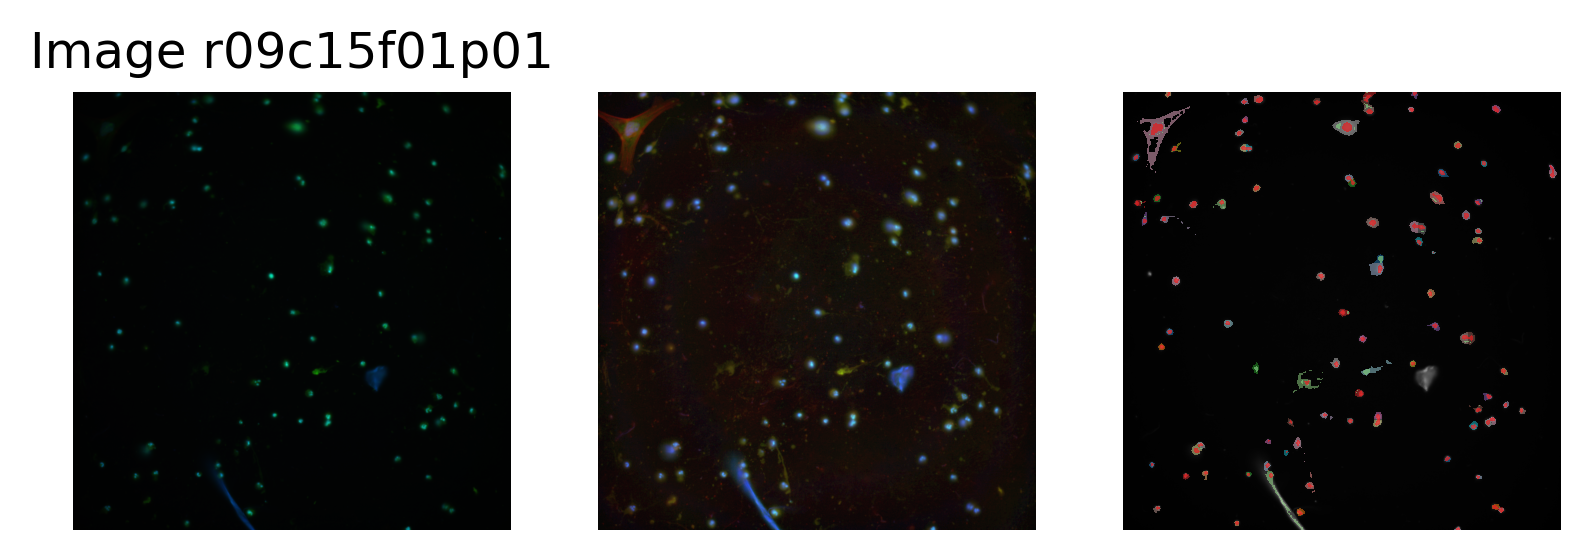

In [85]:
for extreme in vert[:5]:
    well = df_agg.iloc[extreme,:]["Well"]
    id = df_agg.iloc[extreme,:]["ID"]
    print(df_agg.iloc[extreme,:]["Cell Type"])
    print(well)
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

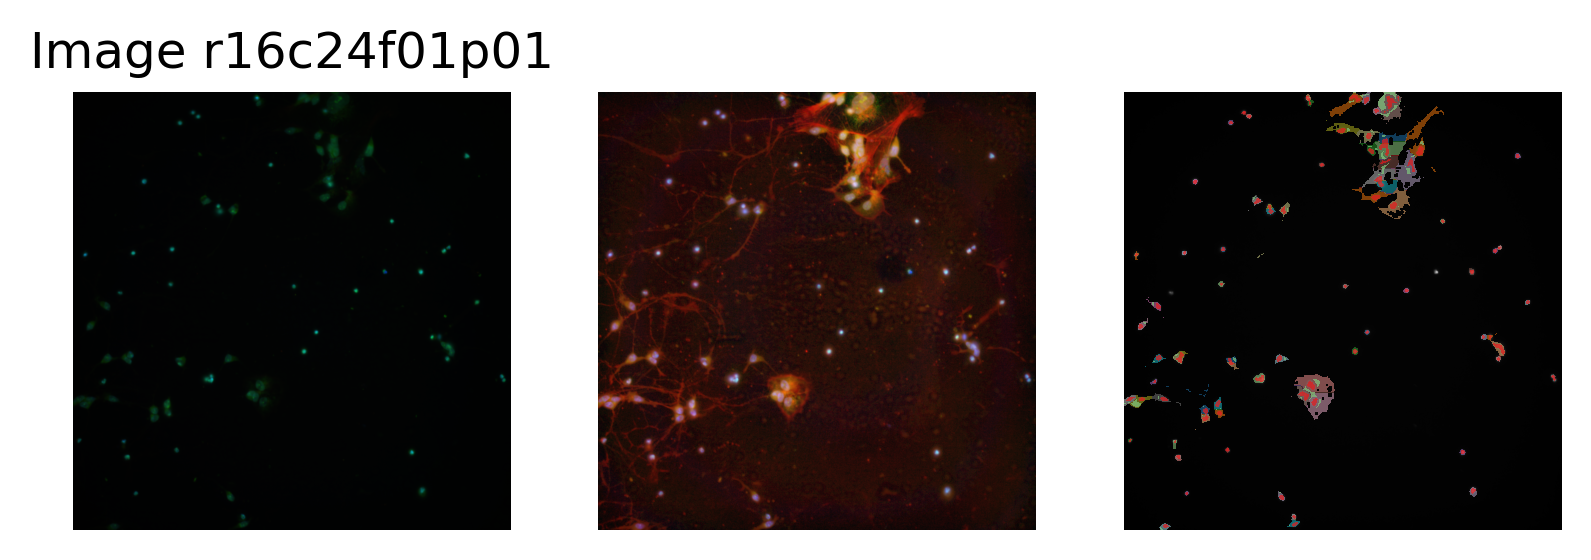

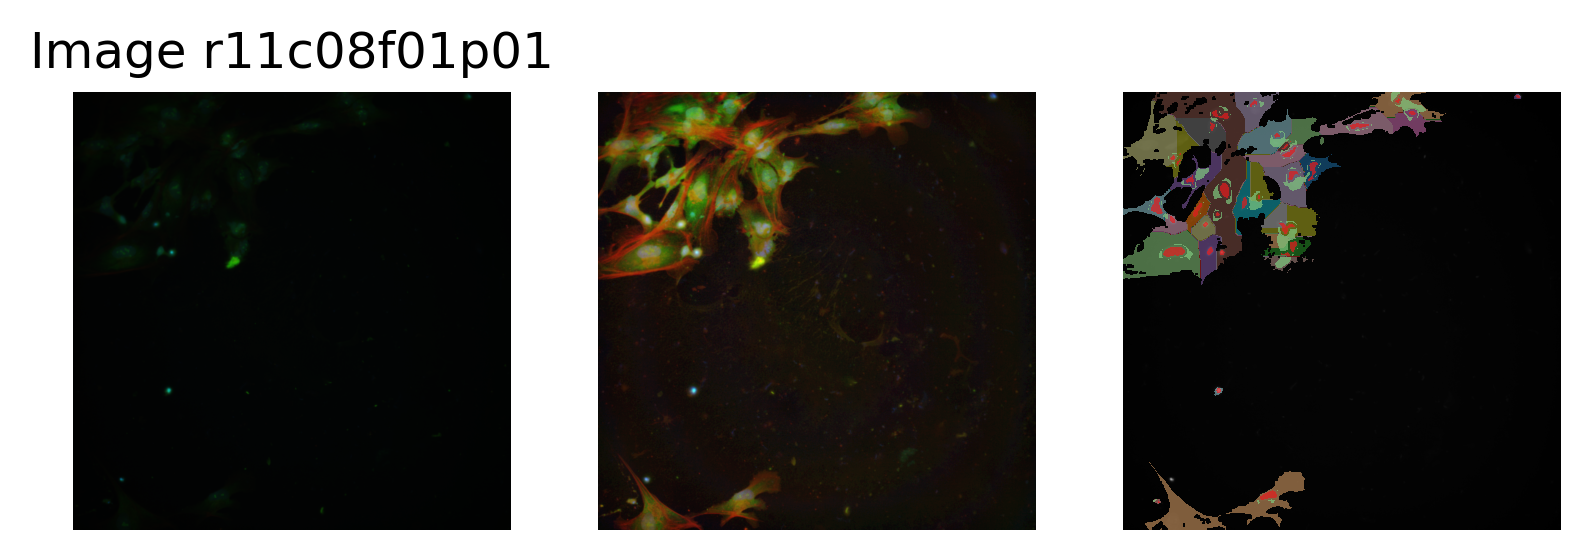

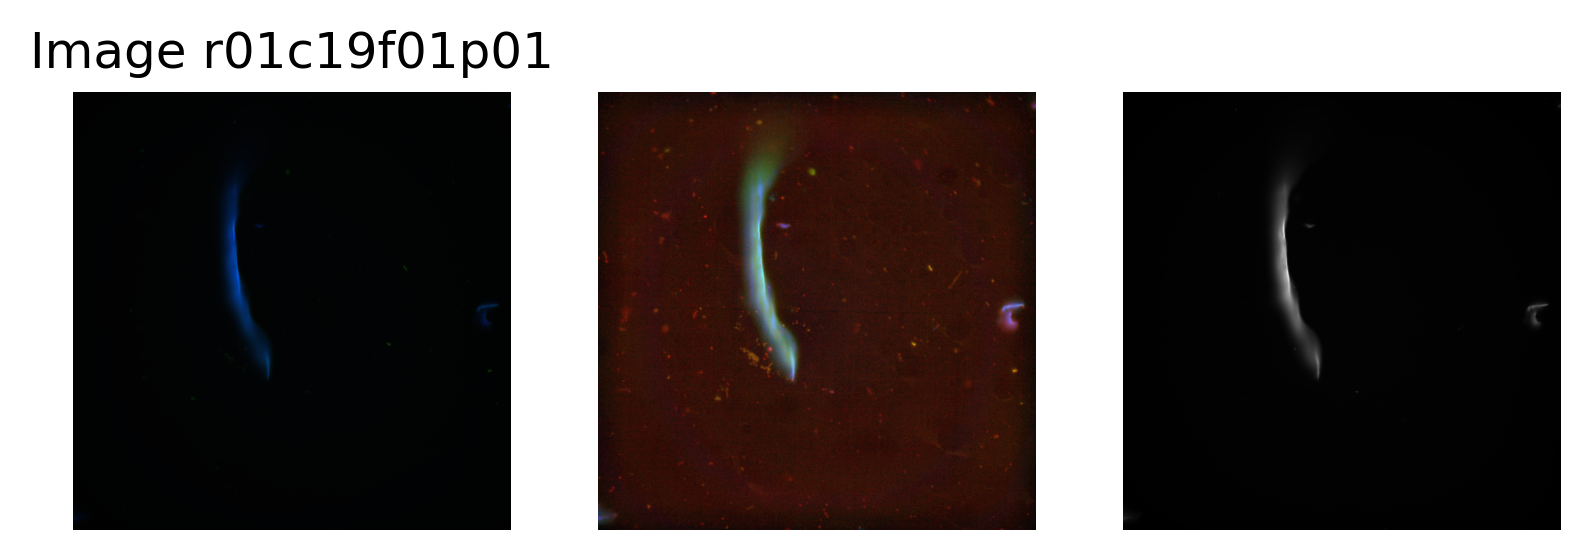

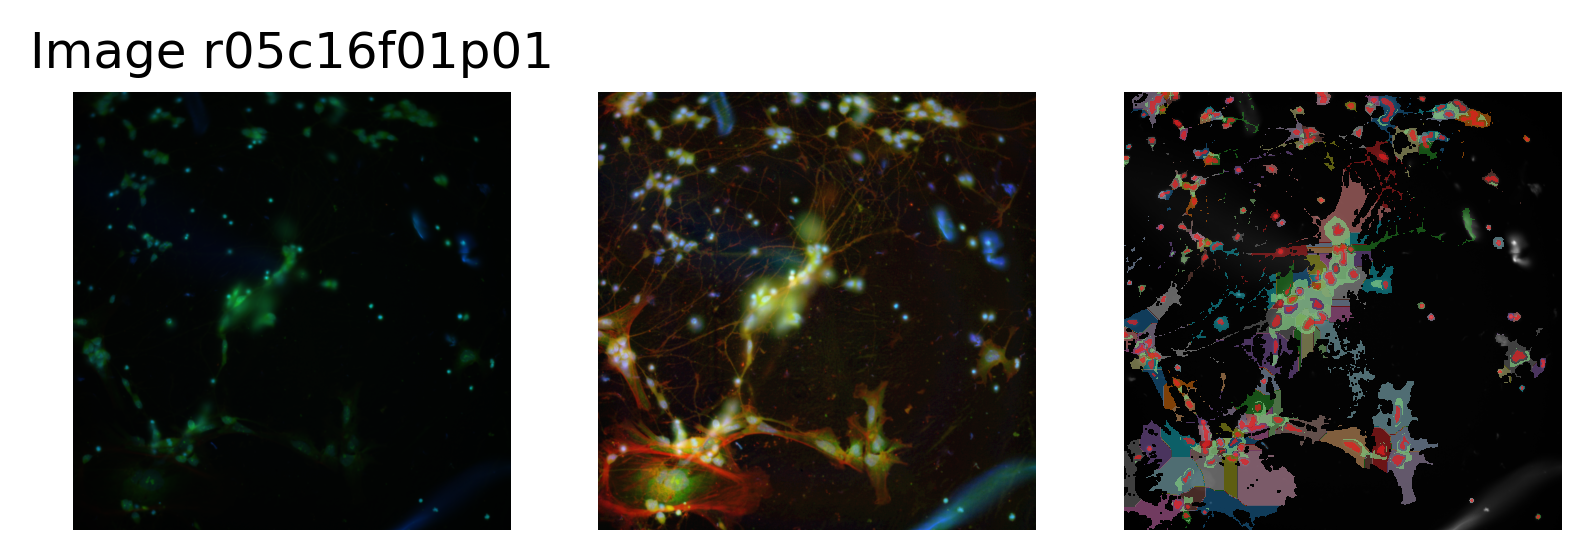

In [82]:

for extreme in [bottom, top, left, right]:
    well = df_agg.iloc[extreme,:]["Well"]
    id = df_agg.iloc[extreme,:]["ID"]
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

# Plot results

In [68]:
data_mean = df_means.to_numpy()
data_mean = np.nan_to_num(data_mean)
#data_mean = [row for row, f in zip(data_mean, field) if f != 5]
D = pairwise_distances(data_mean, metric='cosine')

lim = 9*10
plt.imshow(D[:lim,:lim])
plt.colorbar()

for i in np.arange(0, lim, 9):
    plt.plot([0, lim], [i-0.5, i-0.5], 'r--', linewidth=0.5)
    plt.plot([i-0.5, i-0.5], [0, lim], 'r--', linewidth=0.5)

plt.title("Feature Cosine Distances between Images (First 90)")
plt.xticks([])
plt.yticks([])

ValueError: setting an array element with a sequence.

In [ ]:
data_dist = []
data_type = []
data_ids = []
for i in range(D.shape[0]):
    tile1 = i // 9
    for j in range(i):
        tile2 = j // 9
        data_dist.append(D[i,j])
        data_ids.append((id[i], id[j]))
        if tile1 == tile2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(data = {"Distance": data_dist, "Well Relationship": data_type, "ID Pair": data_ids})
sns.boxplot(df_types, x="Distance", y="Well Relationship")

x = df_types[df_types["Well Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Well Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x,y, alternative="less")
plt.title(f"Inter vs. Intrawell Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})")

In [ ]:
df_outliers = df_types[(df_types["Well Relationship"] == "Same") & (df_types["Distance"] > 0.5)]
for pair in df_outliers["ID Pair"]:
    plot(pair[0], id_to_path_im, id_to_path_seg)
    plt.show()
    plot(pair[1], id_to_path_im, id_to_path_seg)
    plt.show()
    print("**")
    

# Cell Type Distances

Text(0.5, 1.0, 'Inter vs. Intrawell Feature Distances (Mann-Whitney p-val: 0.00E+00)')

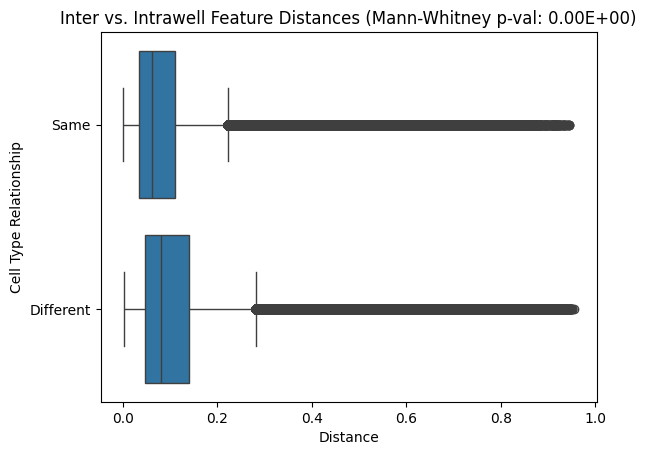

In [17]:
data_dist = []
data_type = []
data_ids = []
for i in range(D.shape[0]):
    type1 = cell_types[i]
    for j in range(i):
        type2 = cell_types[j]
        data_dist.append(D[i,j])
        data_ids.append((id[i], id[j]))
        if type1 == type2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(data = {"Distance": data_dist, "Cell Type Relationship": data_type, "ID Pair": data_ids})
sns.boxplot(df_types, x="Distance", y="Cell Type Relationship")

x = df_types[df_types["Cell Type Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Cell Type Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x,y, alternative="less")
plt.title(f"Inter vs. Intrawell Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})")

# Intrawell distances

In [ ]:
data_dist = []
data_type = []

D_tile = np.zeros((9,9,D.shape[0] // 9))
for i in range(D.shape[0]):
    tile1 = i // 9
    for j in range(i):
        tile2 = j // 9
        if tile1 == tile2:
            f1 = i % 9
            f2 = j % 9
            D_tile[f1, f2, tile1] = D[i,j]


D_tile2 = np.zeros((9,(D.shape[0] // 9)*8))
for field in range(D_tile2.shape[0]):
    distances = []
    for i in range(1,D_tile.shape[0]):
        for j in range(i):
            if i == field or j == field:
                distances += list(D_tile[i,j,:])

    D_tile2[field,:] = distances

dfs = []
for field in range(D_tile2.shape[0]):
    df = pd.DataFrame({"Distance": D_tile2[field,:]})
    df["Field"] = str(field)
    dfs.append(df)
df = pd.concat(dfs)

sns.boxplot(df, x="Distance", y="Field")
plt.title("Distances from Other Fields of Same Well")

# # f, axs = plt.subplots(nrows=9, ncols=9)
# # for i, row in enumerate(axs):
# #     for j, ax in enumerate(row):
# #         sns.histplot(D_tile[i,j,:], ax=ax)
# #         ax.set_xlim(left=0, right=1)

# # f.set_size_inches(20,20)

# f, axs = plt.subplots(ncols=9)
# for i, ax in enumerate(axs):
#     sns.histplot(D_tile2[i,:], ax=ax)
#     ax.set_xlim(left=0, right=1)
# f.set_size_inches(15,5)
